<a href="https://colab.research.google.com/github/aiAintEasy-HolyCalamity/TelecomCustChurnPrediction_xgboost_randomforest/blob/main/CustomerChurnPrediction_telecom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
##Setup and Imports
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report


#Data Loading
##Use the 'raw' URL to access the raw CSV data
dataset_url = 'https://raw.githubusercontent.com/HeteRai/telcom_customer_churn_project/main/data/telco.csv'

#Read the CSV file directly from the URL
data = pd.read_csv(dataset_url)

print('Data shape:', data.shape)
print(data.head())
print(data.info())
print(data.isnull().sum())

Data shape: (7043, 50)
  Customer ID  Gender  Age Under 30 Senior Citizen Married Dependents  \
0  8779-QRDMV    Male   78       No            Yes      No         No   
1  7495-OOKFY  Female   74       No            Yes     Yes        Yes   
2  1658-BYGOY    Male   71       No            Yes      No        Yes   
3  4598-XLKNJ  Female   78       No            Yes     Yes        Yes   
4  4846-WHAFZ  Female   80       No            Yes     Yes        Yes   

   Number of Dependents        Country       State  ...  \
0                     0  United States  California  ...   
1                     1  United States  California  ...   
2                     3  United States  California  ...   
3                     1  United States  California  ...   
4                     1  United States  California  ...   

  Total Extra Data Charges  Total Long Distance Charges  Total Revenue  \
0                       20                         0.00          59.65   
1                        0         

In [21]:
# Data Preprocessing
data['Total Long Distance Charges'] = pd.to_numeric(data['Total Long Distance Charges'], errors='coerce')
data.fillna(data['Total Long Distance Charges'].median(), inplace=True)
data.drop(['Customer ID'], axis=1, inplace=True)


In [23]:
# Encoding categorical variables
label_cols = ['Gender', 'Married', 'Dependents', 'Age', 'Under 30', 'Churn Label']
for col in label_cols:
    data[col] = LabelEncoder().fit_transform(data[col])


In [24]:
# One-hot encoding for remaining categorical variables
data = pd.get_dummies(data)

In [26]:
# Scaling numerical features
scaler = StandardScaler()
numerical_cols = ['Total Extra Data Charges', 'Total Revenue', 'Total Long Distance Charges']
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])

In [28]:
# Splitting data into features and target
X = data.drop('Churn Label', axis=1)
y = data['Churn Label']

In [29]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [31]:
#Model Building and Training
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

In [33]:
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f'\n{name} Accuracy: {accuracy_score(y_test, y_pred)}')
    print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression Accuracy: 0.9077141504969238
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1524
           1       0.84      0.82      0.83       589

    accuracy                           0.91      2113
   macro avg       0.89      0.88      0.88      2113
weighted avg       0.91      0.91      0.91      2113


Random Forest Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1524
           1       1.00      1.00      1.00       589

    accuracy                           1.00      2113
   macro avg       1.00      1.00      1.00      2113
weighted avg       1.00      1.00      1.00      2113


XGBoost Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1524
           1       1.00      1.00      1.00       589

    accuracy                           1.00      2113
   macro avg       1.00   

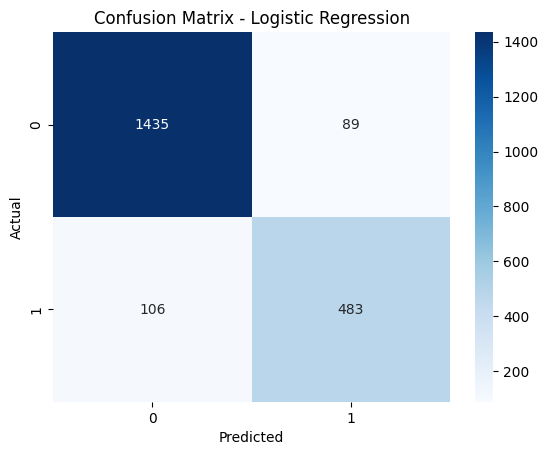

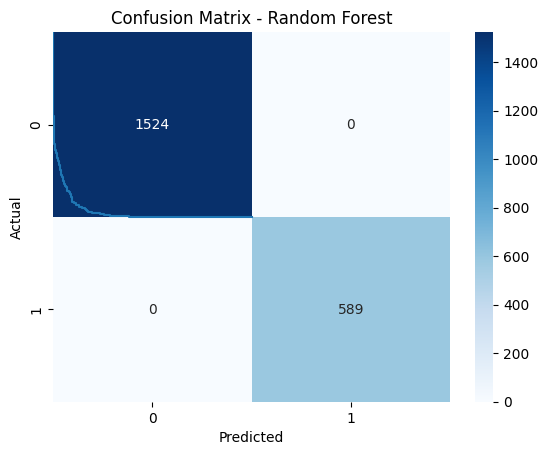

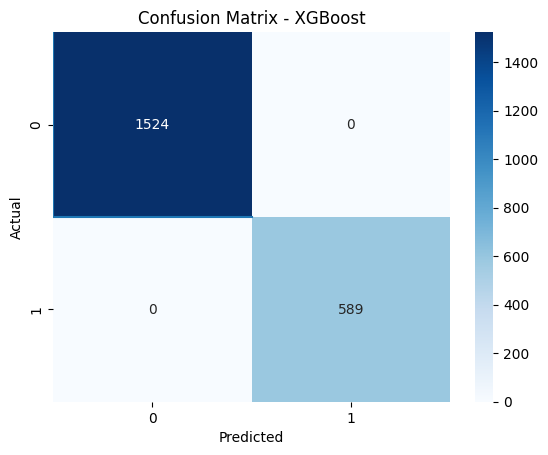

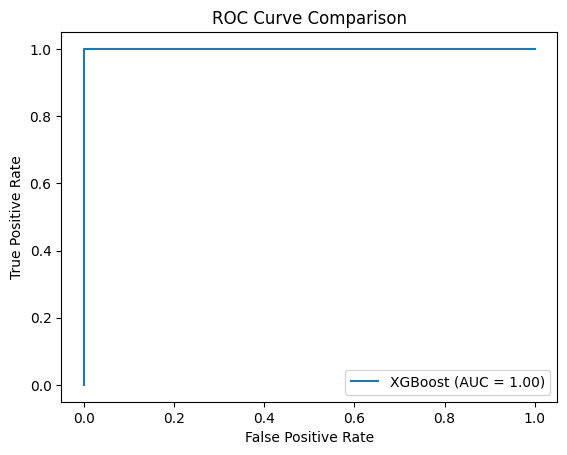

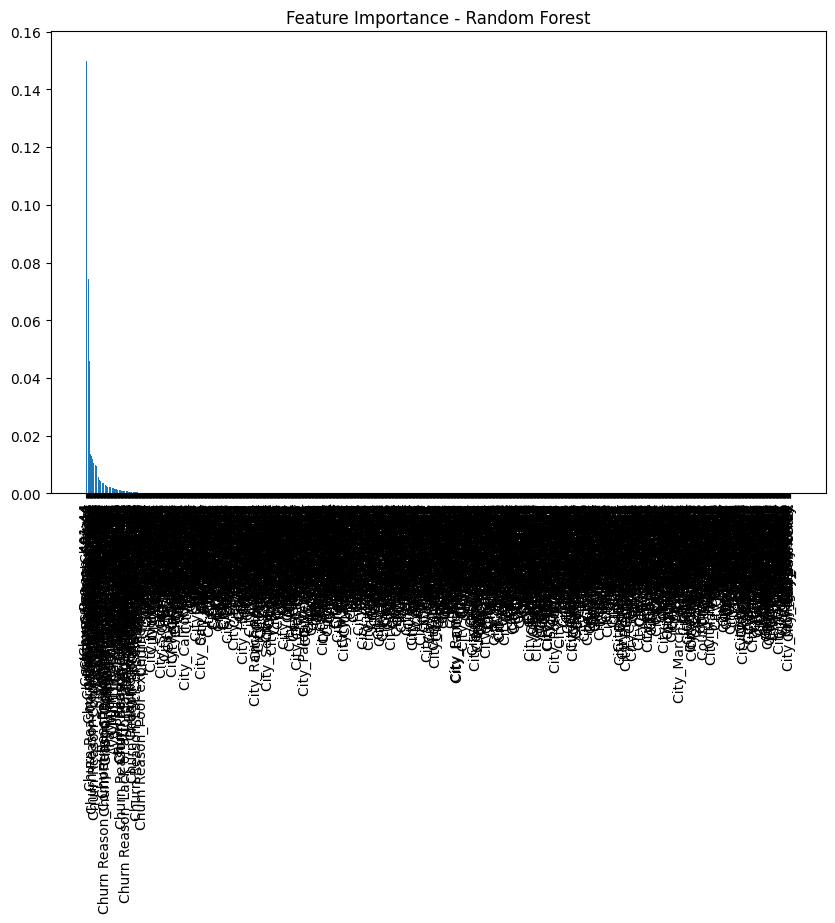

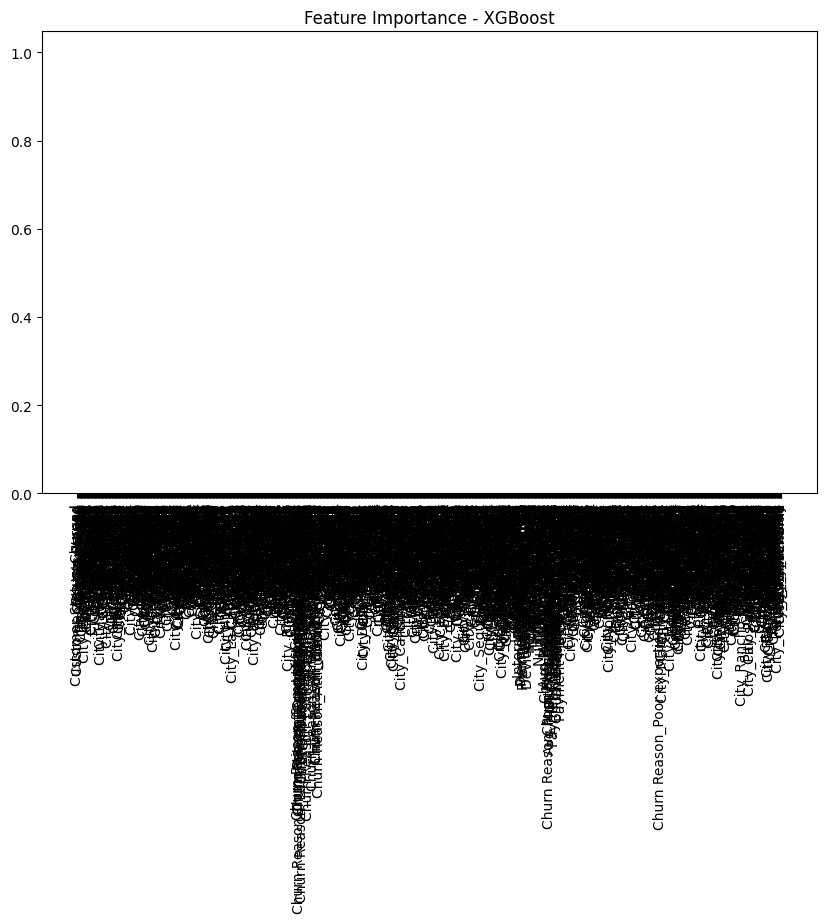

In [34]:
#Model Evaluation and Visualization
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

for name, model in models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, name)

    # ROC Curve and AUC
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

# Feature Importance (for Random Forest and XGBoost)
def plot_feature_importance(model, model_name):
    importance = model.feature_importances_
    feature_names = X.columns
    indices = np.argsort(importance)[::-1]
    plt.figure(figsize=(10, 6))
    plt.title(f'Feature Importance - {model_name}')
    plt.bar(range(len(indices)), importance[indices], align='center')
    plt.xticks(range(len(indices)), [feature_names[i] for i in indices], rotation=90)
    plt.show()

for name, model in models.items():
    if hasattr(model, 'feature_importances_'):
        plot_feature_importance(model, name)